In [157]:
# from sim_bfr_240611.config import RAW_DATA_DIR
RAW_DATA_DIR = 'Greg_simulation'
import scipp as sc
import plopp as pp
import scippneutron as scn
import scippnexus as snx


In [158]:
filename=RAW_DATA_DIR +"/BIFROST_20240610T151842.h5"
dg = snx.File(filename)

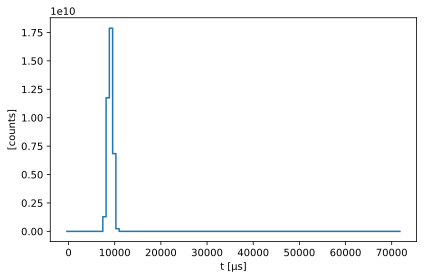

In [159]:
dg['/entry/instrument/']['data']['time', 1].plot()


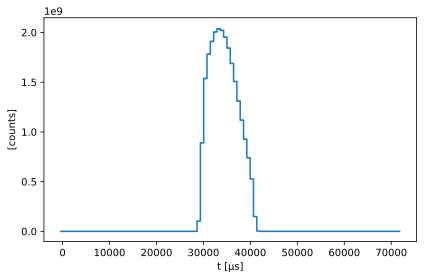

In [160]:
dg['/entry/instrument/090_frame_1']['data']['time', 1].plot()


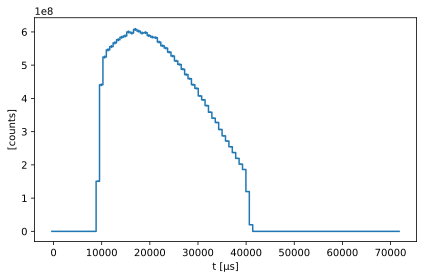

In [161]:

dg['/entry/instrument/097_frame_2']['data']['time', 1].plot()


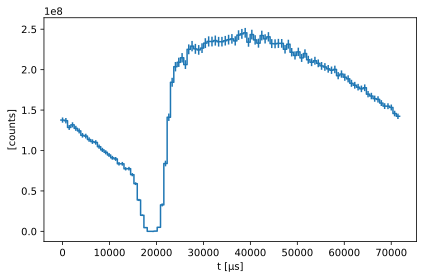

In [162]:
dg['/entry/instrument/110_frame_3']['data']['time', 1].plot()


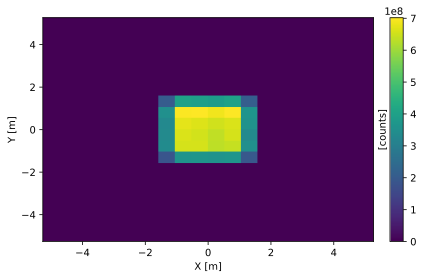

In [163]:
dg['/entry/instrument/111_psd0']['data']['time', 1].plot()


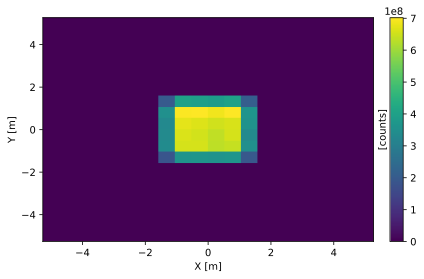

In [164]:
dg['/entry/instrument/113_psd1']['data']['time', 1].plot()


In [165]:
dg['/entry/instrument/123_channel_1_1_triplet']['data']

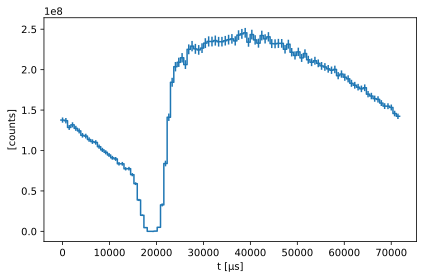

In [166]:
dg['/entry/instrument/110_frame_3']['data']['time', 1].plot()


In [167]:
with snx.File(filename) as f:
    print(list(f.keys()))

['entry', 'mcstas']


In [168]:
a=dg['/entry/instrument/007_frame_0']['data'][...]
a['time',0]

<scipp.DataArray>
Dimensions: Sizes[t:102, ]
Coordinates:
* t                         float64            [µs]  (t [bin-edge])  [-353.607, 353.607, ..., 71075, 71782.2]
  time                    datetime64             [ns]  ()  2024-06-10T15:20:49.896447022
Data:
                            float64         [counts]  (t)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

In [169]:
dg['/entry/instrument/007_frame_0']['data']['time',0]

<scipp.DataArray>
Dimensions: Sizes[t:102, ]
Coordinates:
* t                         float64            [µs]  (t [bin-edge])  [-353.607, 353.607, ..., 71075, 71782.2]
  time                    datetime64             [ns]  ()  2024-06-10T15:20:49.896447022
Data:
                            float64         [counts]  (t)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

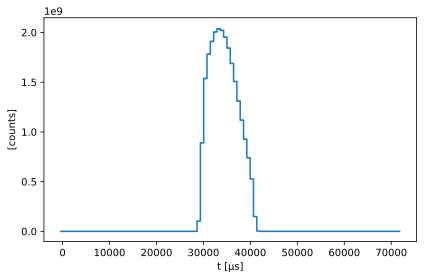

In [170]:
dg['/entry/instrument/090_frame_1']['data']['time', 1].plot()

In [187]:
example_data=dg['/entry/instrument/090_frame_1']['data']['time',1]
example_data=dg['/entry/instrument/007_frame_0']['data']['time',1]

example_data.coords['t']=sc.midpoints(example_data.coords['t']) # convert from bin edges to bin centers


In [189]:


import numpy as np
from easyscience.Objects.new_variable import Parameter
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter
import matplotlib.pyplot as plt

# def Gaussian(x: np.ndarray, A: float, mu: float, sigma: float) -> np.ndarray:
def Gaussian(x: np.ndarray) -> np.ndarray:
# def Gaussian(x, A,mu,sigma) -> np.ndarray:
    """
    Mathematical model for a Gaussian function.
    
    :x: values to calculate the model over. 
    :A: amplitude of the Gaussian.
    :mu: mean (center) of the Gaussian.
    :sigma: standard deviation of the Gaussian.
    
    :return: model values.
    """
    return A.value * np.exp(-0.5 * ((x - mu.value) / sigma.value) ** 2)+BG.value

#Create easyscience Parameters with starting values
A=Parameter(name='A', value=2e9, fixed=False,min=0)
# mu=Parameter(name='mu', value=30000, fixed=False)
mu=Parameter(name='mu', value=9000, fixed=False)
sigma=Parameter(name='sigma', value=1500, fixed=False,min=0)
BG=Parameter(name='BG', value=0.1, fixed=False,min=0)

#Create easyscience BaseObj with the Gaussian model and the Parameters
Gaussian_Obj = BaseObj(name='Gaussian', A=A, mu=mu, sigma=sigma,BG=BG)
f = Fitter(Gaussian_Obj, Gaussian )


In [190]:
# bin_edges=example_data.coords['t'].values
# bin_centers=(bin_edges[:-1] + bin_edges[1:]) / 2
# x=bin_centers

x=example_data.coords['t'].values
y=example_data.values
yerr=np.sqrt(example_data.variances+1e7) # adding a constant to the variance to avoid problems at the tails

res=f.fit(x=x, y=y, weights=1/yerr)
# res=f.fit(x=x, y=y, weights=np.sqrt(y))
A,mu,sigma,BG



(<Parameter 'A': 21156671054.3826 ± 813569699.4830, bounds=[0.0:inf]>,
 <Parameter 'mu': 9160.8479 ± 16.3283, bounds=[-inf:inf]>,
 <Parameter 'sigma': 444.6708 ± 5.6580, bounds=[0.0:inf]>,
 <Parameter 'BG': 12.7157 ± 11458.1423, bounds=[0.0:inf]>)

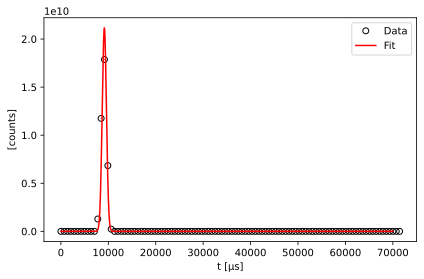

In [197]:

# Put the fit into a DataArray

# Plot the fit on a smoother curve by using more points
xx=np.linspace(0,70000,5000)

fit_values=sc.array(values=Gaussian(xx),dims='t',unit='counts')
Fit=sc.DataArray(data=fit_values,coords={'t': sc.array(values=xx,dims='t',unit='micro*s')})

data_and_fit=sc.DataGroup({'Data': example_data,
                          'Fit': Fit})

pp.plot(data_and_fit,
        linestyle=         {'Data': 'none',    'Fit': '-'},
        marker=            {'Data': 'o',       'Fit':'none'},
        markerfacecolor=   {'Data': 'none',    'Fit':'red'},
        color=             {'Data': 'black',   'Fit':'red'})
# pp.plot(
#     'Data': example_data,marker='o',color='black',markerfacecolor='white')
